# Whole Cell MSMR User Guide

This notebook is designed to help guide user in how to use the MSMR software that was used in the following publication. Here, we will

1. Show how to look at individual reactions
2. Look at a whole electrode response
3. Look at a whole cell response
4. Import and process experimental capacity and voltage data to also get differential voltage
5. Perform fitting routine
6. Explore different constraints

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy.optimize import fmin_slsqp
from utilities import msmr as msmr
from utilities import plotting as mp

plt.style.use('default')

### 1. Individual Reactions

The framework of the MSMR model is based on the idea that each electrode's thermodynamics is made up of separate reactions (or phase transitions), and that each of these different reactions can be separately modeled by three parameters

* $U_{j}^{0}$ : Standard electrode potential
* $X_{j}$ (or $Q_{j})$ : Maximum fractional occupancy
* $\omega_{j}$ : Thermodynamic factor

A note is that if you were to replace the Xj value with an extensive form (capacity) instead, the model will solve in the same way. Then, it is up to the user to ensure that the extensive form accurately reflects the intensive, Xj, form.

In [2]:
# Here we'll take a simple reaction, with the standard electrode potential centered at 3.5
# with a maximum fractional occupancy of 0.25, and wj of 1, which represents ideal Nernstian behavior
reaction_1 = [3.5, 0.25, 1]

# The function, msmr.individual_reactions will solve the xj (fractional occupancy) and 
# dxjdu (analog of differential capacity) values at any given potential
xj, dxjdu = msmr.individual_reactions(3.5, reaction_1[0], reaction_1[1], reaction_1[2], 298)
print(xj, dxjdu)

0.125 -2.433960546857972


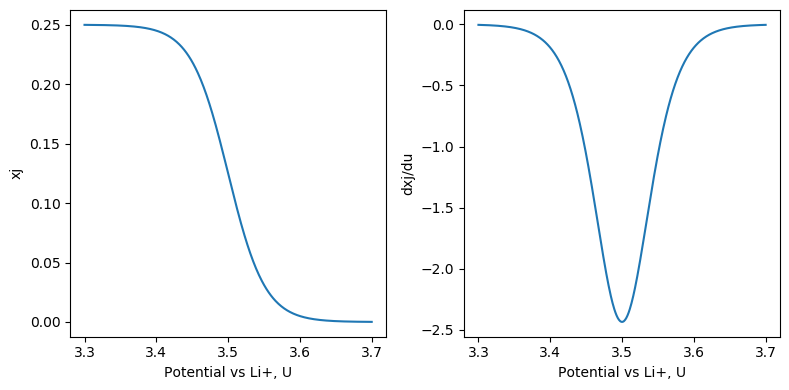

In [3]:
# Instead of solving just one potential, we can give the function a list or array of voltages

voltages = np.linspace(3.3, 3.7, 500)
xj, dxjdu = msmr.individual_reactions(voltages, reaction_1[0], reaction_1[1], reaction_1[2], 298)

fig = plt.figure(figsize=(8,4))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax1.plot(voltages, xj)
ax1.set_xlabel('Potential vs Li+, U')
ax1.set_ylabel('xj')
ax2.set_xlabel('Potential vs Li+, U')
ax2.set_ylabel('dxj/du')
ax2.plot(voltages, dxjdu)
plt.tight_layout()

Now, most electrodes undergo a number of different phase transitions and have multiple reactions. Using the MSMR framework, we can see how all these reactions differ

To start, one must have a baseline library of parameters for this model. A great resource is the paper "Thermodynamic Model for Substitutional Materials: Application to Lithiated Graphite, Spinel Manganese Oxide, Iron Phosphate, and Layered Nickel-Manganese-Cobalt Oxide" by Verbrugge et al., (2017) in JES, where they perform fits for four different, very common, insertion electrodes. For this example, we will use their parameters for NMC.

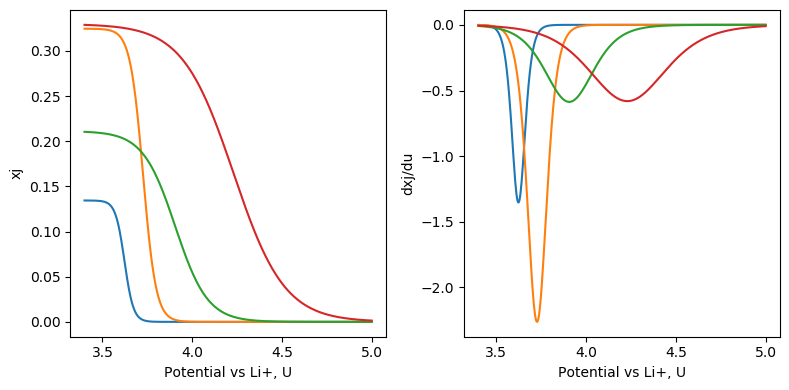

In [4]:
# The model uses 1D arrays, so we must input all our parameters in a 1D array. Each reaction will
# have 3 parameters, so the array must be number_of_reactions * 3 long. Here, we have 4 reactions
# and thus we have 12 different parameters

nmc_parameters = np.array([3.62274, 0.13442, 0.96710,
                           3.72645, 0.32460, 1.39712,
                           3.90575, 0.21118, 3.50500,
                           4.22955, 0.32980, 5.52757])

# Setting up variables and figure
nor_nmc = 4
voltages = np.linspace(3.4, 5.0, 500)
fig = plt.figure(figsize=(8,4))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

# Looping through the parameter matrix
for i in range(0,nor_nmc):
    xj, dxjdu = msmr.individual_reactions(voltages, nmc_parameters[0+(i*3)], nmc_parameters[1+(i*3)],
                                          nmc_parameters[2+(i*3)], 298)
    ax1.plot(voltages, xj, label='j={}'.format(i+1))
    ax2.plot(voltages, dxjdu)
    
ax1.set_xlabel('Potential vs Li+, U')
ax1.set_ylabel('xj')
ax2.set_xlabel('Potential vs Li+, U')
ax2.set_ylabel('dxj/du')
plt.tight_layout()

## Electrode Response
Now that we see each individual reaction within an electrode, we now can sum up all the xj and dxjdu values to get the cumulative response at any given potential. This is easily done through the following function. Once plotted, you can see how each individual reaction contributes to the overall curve.

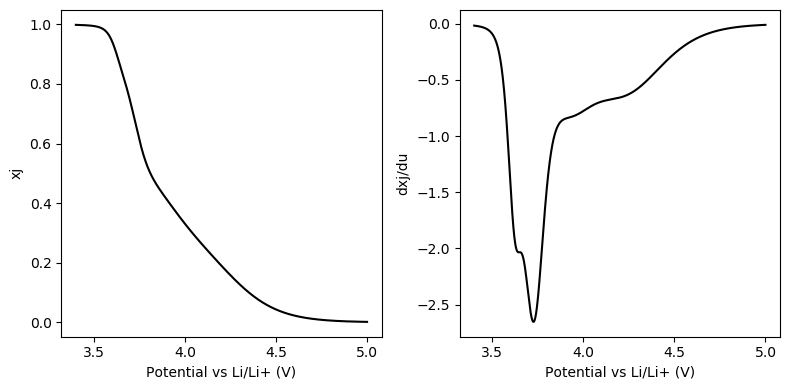

In [5]:
pos_volt, pos_xj, pos_dxjdu = msmr.electrode_response(nmc_parameters, 298, 3.4, 5, 4)

fig = plt.figure(figsize=(8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)

ax.plot(pos_volt, pos_xj,color='k')
ax.set_xlabel('Potential vs Li/Li+ (V)')
ax.set_ylabel('xj')

ax2.plot(pos_volt, pos_dxjdu, color='k')
ax2.set_xlabel('Potential vs Li/Li+ (V)')
ax2.set_ylabel('dxj/du')

plt.tight_layout()

### Whole Cell Response

To get a whole cell response, we have to have our array now contain all the parameters for both sets of the electrodes. However, to adapt the half-cell model above into the whole-cell paradigm, several variables have to be defined.

* Positive electrode capacity
* Negative electrode capacity (or an N-P ratio) 
* Lower bound of the utilization for both electrodes
* Usable capacity within a voltage window


In [6]:
# We first need a parameter matrix that has parameters for both the positive and negative electrode. 
# Here we will use the example in the corresponding work, an LiNMC/LMO | Graphite Cell. 


# For our electrodes, we know that this is a blended cathode, so we correct the Xj (or Qj) parameters
# to accurately reflect the 66% NMC | 34% LMO blend we have.
nmc_cap, lmo_cap = 200, 120 # mAh/g # , 120 mAh/g # Source = Nitta (2017)
nmc_mass_percent, lmo_mass_percent = 0.66, 0.34
nmc_cap_percent = (nmc_mass_percent*nmc_cap)/(nmc_mass_percent*nmc_cap + lmo_mass_percent*lmo_cap)
lmo_cap_percent = (lmo_mass_percent*lmo_cap)/(nmc_mass_percent*nmc_cap + lmo_mass_percent*lmo_cap)


blend_matrix = np.array([3.62274, 0.13442*nmc_cap_percent, 0.96710,
                         3.72645, 0.32460*nmc_cap_percent, 1.39712,
                         3.90575, 0.21118*nmc_cap_percent, 3.50500,
                         4.22955, 0.32980*nmc_cap_percent, 5.52757,
                         4.01173, 0.55070*lmo_cap_percent, 1.52000,
                         4.14902, 0.44930*lmo_cap_percent, 0.93000])

graphite_matrix = np.array([0.08843, 0.43336, 0.08611,
                            0.12799, 0.23963, 0.08009,
                            0.14331, 0.15018, 0.72469,
                            0.16984, 0.05462, 2.53277,
                            0.21446, 0.06744, 0.09470,
                            0.36325, 0.05476, 5.97354])

params = np.append(blend_matrix, graphite_matrix)

print('Now the combined parameter matrix is the following:')
print(params)

Now the combined parameter matrix is the following:
[3.62274    0.10268194 0.9671     3.72645    0.24795833 1.39712
 3.90575    0.16131806 3.505      4.22955    0.25193056 5.52757
 4.01173    0.13002639 1.52       4.14902    0.10608472 0.93
 0.08843    0.43336    0.08611    0.12799    0.23963    0.08009
 0.14331    0.15018    0.72469    0.16984    0.05462    2.53277
 0.21446    0.06744    0.0947     0.36325    0.05476    5.97354   ]


G:\My Drive\A- Research\github\msmr-whole-cell-manuscript\jupyter\utilities\msmr.py:91: RuntimeWarning: overflow encountered in square
  dxjdu = (-Xj/w)*((f*np.exp(f*(U-U0)/w))/(1+np.exp(f*(U-U0)/w))**2)


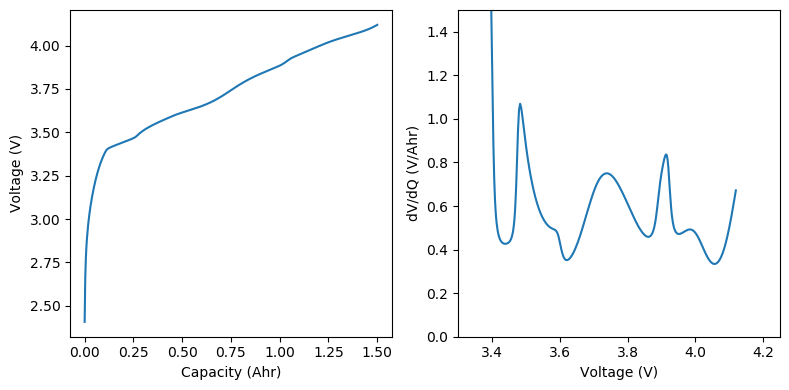

In [7]:
# With this parameter matrix, we can now compute the whole cell MSMR model simple with the 
# following equation, but there are a lot of inputs that must be fed in. The full list is
# explained in the documentation.

# Here, the parameter "all_output" is set to False so we get back just our whole-cell response

cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=params, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = 0.15, neg_lower_li_limit = 0.0,
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = 1.5, Qj_or_Xj='Xj', n_p=1.1, p_capacity=1.8, 
                                           all_output=False)

# Plotting
fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(cap, voltage)
ax.set_xlabel('Capacity (Ahr)')
ax.set_ylabel('Voltage (V)')
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0,1.5)
ax2.set_xlim(3.3, 4.25)
plt.tight_layout()

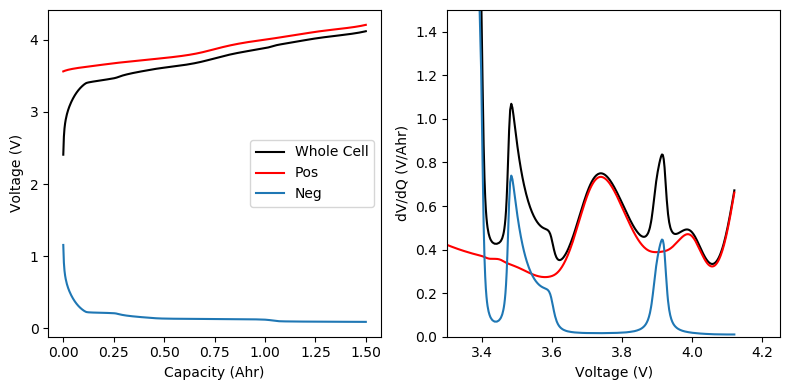

In [8]:
# Alternatively, we can see "all_output" to be True and it will instead give us back all the results
# for each electrode in addition to the whole cell. Here, we have one major result, that gets
# unpacked into a list of capacities, voltages, etc. Then the notation is that 
# 0 = Whole Cell, 1 = Positive Electrode, 2 = Negative Electrode

# With this parameter matrix, we can now compute the whole cell MSMR model simple with the 
# following equation, but there are a lot of inputs that must be fed in. The full list is
# explained in the documentation.

# Here, the parameter "all_output" is set to False so we get back just our whole-cell response

results = msmr.whole_cell(parameter_matrix=params, nor_pos = 6, nor_neg = 6,
                          pos_lower_li_limit = 0.15, neg_lower_li_limit = 0.0,
                          temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                          usable_cap = 1.5, Qj_or_Xj='Xj', n_p=1.1, p_capacity=1.8, 
                          all_output=True)

caps, volts, dqdus, dudqs = results

# Plotting
# When plotting the positive electrode x-coordinates has to be flipped, since in a whole cell,
# the pos electrode is losing Li. This is accounted for in the solving of the MSMR software and
# all x-variables are evenly spaced for proper flipping.

fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(caps[0], volts[0], label='Whole Cell', color='k')
ax.plot(np.flip(caps[0]), volts[1], label='Pos', color='r')
ax.plot(caps[0], volts[2], label='Neg')
ax.set_xlabel('Capacity (Ahr)')
ax.set_ylabel('Voltage (V)')
ax.legend()

ax2.plot(volts[0], -dudqs[0], color='k')
ax2.plot(np.flip(volts[0]), -dudqs[1], color='r')
ax2.plot(volts[0], -dudqs[2])
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0,1.5)
ax2.set_xlim(3.3, 4.25)
plt.tight_layout()

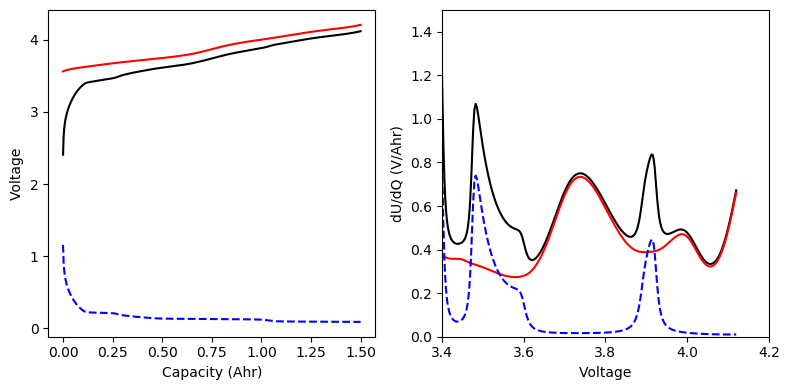

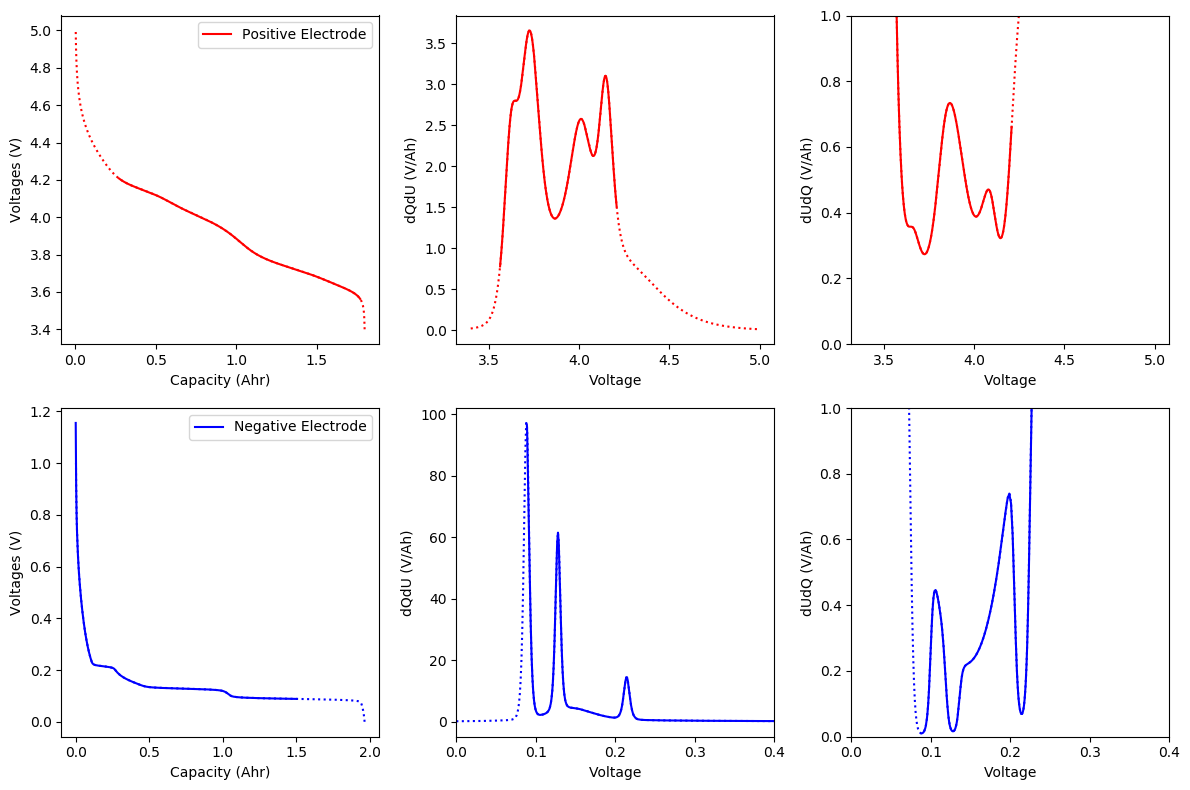

In [9]:
# We can even take these results and go a step further to see what portions of each electrode
# are being used with the following plotting function that uses the all_output results and
# the individual electrodes.

# Since our parameters are in the intensive form, we have 

pos_volt, pos_xj, pos_dxjdu = msmr.electrode_response(blend_matrix, 298, 3.4, 5, 6)
neg_volt, neg_xj, neg_dxjdu = msmr.electrode_response(graphite_matrix, 298, 0, 1, 6)

# Because the initial Xj parameters are intensive, we have to convert the xj's into their
# extensive form before comparing with the whole-cell results.
pos_whole_0 = (pos_volt, pos_xj*1.8, pos_dxjdu*1.8)
neg_whole_0 = (neg_volt, neg_xj*1.8*1.1, neg_dxjdu*1.8*1.1)

fig_1_0, fig_2_0 = mp.individual_electrode_analysis(results, pos_whole_0, neg_whole_0)


In [10]:
# We can also immediately convert all our Xj variables into the extensive form using the 
# following estimates. The software recognizes this through the and will adapt to whichever
# form of the lithiation or capacity parameters.

pos_q = 1.8 # True insertion capacity of positive electrode
n_p = 1.1
neg_q = pos_q * n_p

blend_matrix_q = np.array([3.62274, 0.13442*nmc_cap_percent*pos_q, 0.96710,
                           3.72645, 0.32460*nmc_cap_percent*pos_q, 1.39712,
                           3.90575, 0.21118*nmc_cap_percent*pos_q, 3.50500,
                           4.22955, 0.32980*nmc_cap_percent*pos_q, 5.52757,
                           4.01173, 0.55070*lmo_cap_percent*pos_q, 1.52000,
                           4.14902, 0.44930*lmo_cap_percent*pos_q, 0.93000])

graphite_matrix_q = np.array([0.08843, 0.43336*neg_q, 0.08611,
                              0.12799, 0.23963*neg_q, 0.08009,
                              0.14331, 0.15018*neg_q, 0.72469,
                              0.16984, 0.05462*neg_q, 2.53277,
                              0.21446, 0.06744*neg_q, 0.09470,
                              0.36325, 0.05476*neg_q, 5.97354])

params_q = np.append(blend_matrix_q, graphite_matrix_q)

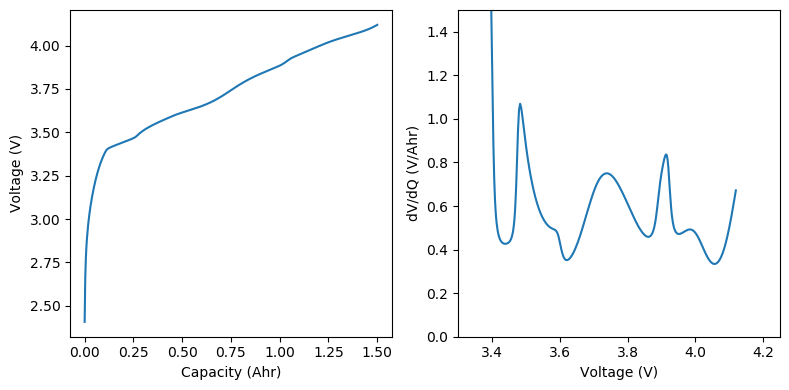

In [11]:
# If we're converting to Q, you have to be sure to set your lower_li_limits to also reflect the
# change from xj to Qj.

# If we're also using the extensive form, then the n_p and p_capacity variables were already taken
# into consideration and can be left as "None"
cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=params_q, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = 0.27, neg_lower_li_limit = 0.0,
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = 1.5, Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                                           all_output=False)

# Plotting
fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(cap, voltage)
ax.set_xlabel('Capacity (Ahr)')
ax.set_ylabel('Voltage (V)')
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0,1.5)
ax2.set_xlim(3.3, 4.25)
plt.tight_layout()

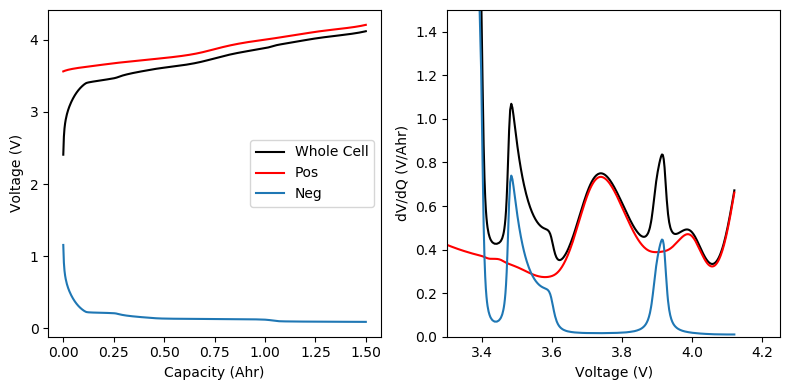

In [12]:
results = msmr.whole_cell(parameter_matrix=params_q, nor_pos = 6, nor_neg = 6,
                          pos_lower_li_limit = 0.27, neg_lower_li_limit = 0.0,
                          temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                          usable_cap = 1.5, Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                          all_output=True)

caps, volts, dqdus, dudqs = results

# Plotting
# When plotting the positive electrode x-coordinates has to be flipped, since in a whole cell,
# the pos electrode is losing Li. This is accounted for in the solving of the MSMR software and
# all x-variables are evenly spaced for proper flipping.

fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(caps[0], volts[0], label='Whole Cell', color='k')
ax.plot(np.flip(caps[0]), volts[1], label='Pos', color='r')
ax.plot(caps[0], volts[2], label='Neg')
ax.set_xlabel('Capacity (Ahr)')
ax.set_ylabel('Voltage (V)')
ax.legend()

ax2.plot(volts[0], -dudqs[0], color='k')
ax2.plot(np.flip(volts[0]), -dudqs[1], color='r')
ax2.plot(volts[0], -dudqs[2])
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0,1.5)
ax2.set_xlim(3.3, 4.25)
plt.tight_layout()

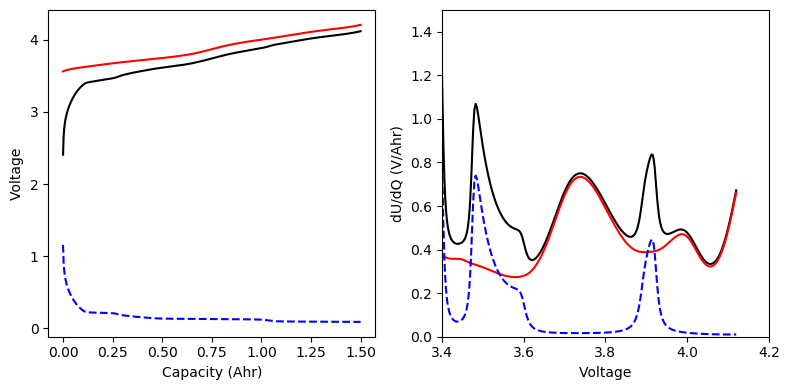

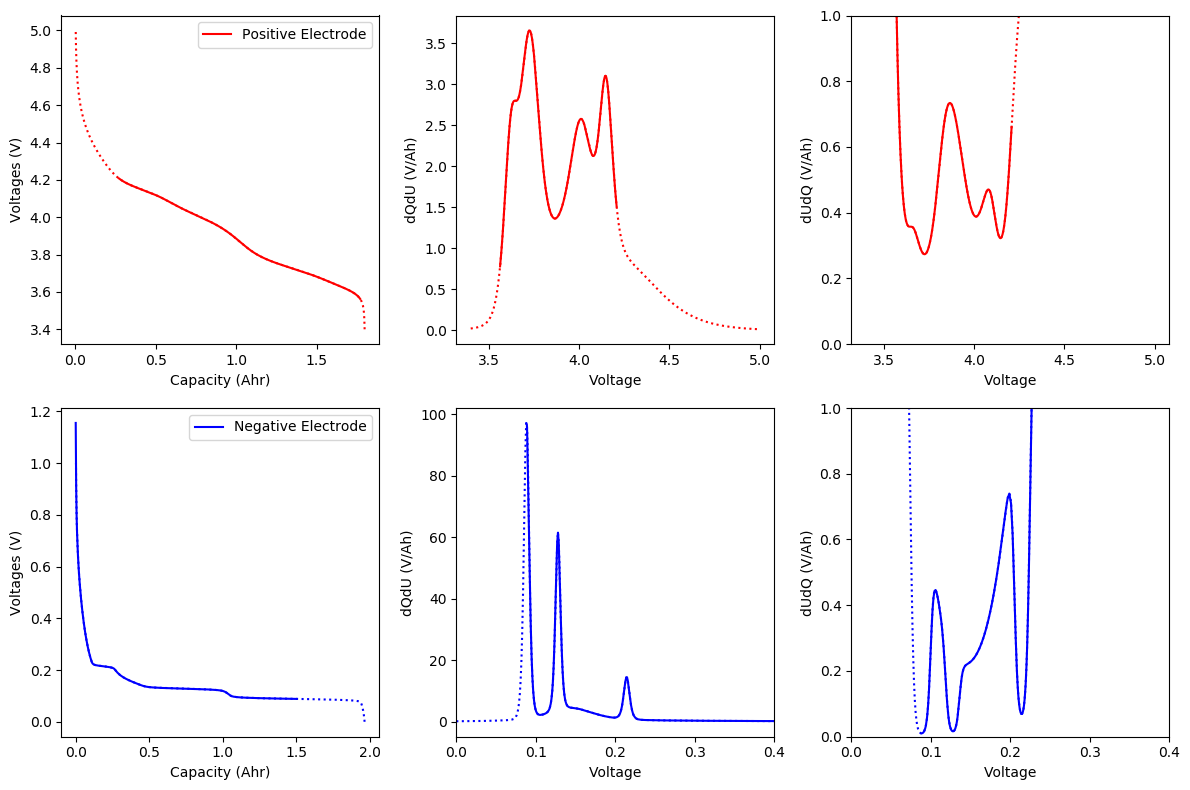

In [13]:
# Since we used the extensive forms of the capacity or lithiation parameter, it is already
# accounted for and we can just plug this straight in.

pos_whole_0 = msmr.electrode_response(blend_matrix_q, 298, 3.4, 5, 6)
neg_whole_0 = msmr.electrode_response(graphite_matrix_q, 298, 0, 1, 6)

fig_1_0, fig_2_0 = mp.individual_electrode_analysis(results, pos_whole_0, neg_whole_0)

## Importing Sample Data and Fitting

Here, we will import some sample experimental data and then do subsequent fits to explore different constraints. This loading function is specific to the Maccor output structure, and should be adapted to best fit the data structure you may have. Here, we are working with a low constant-current experiment, so we will take the voltage-time data and use a Savitzy Golay filter over 99 points to get the first derivative, or dU/dQ.

The function will use a designated voltage range in which you want to perform fitting over, and gather the capacity and differential voltage at each of the corresponding voltages.

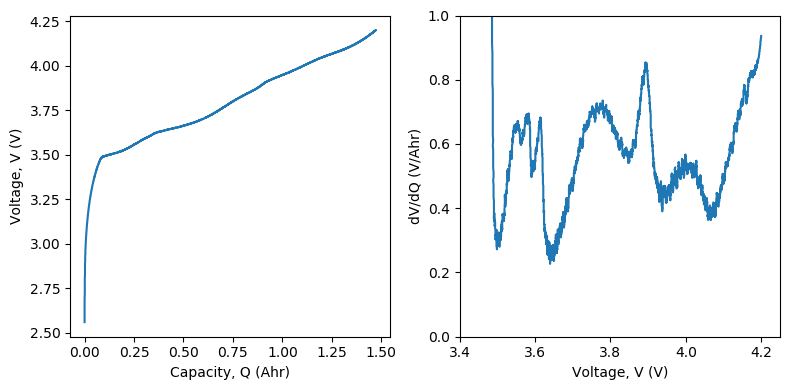

In [14]:
# Loading in voltage, current, capacity, dudq, and the interpolated values for each cell
voltage_range_c = np.linspace(3.49, 4.15, 1000)
folderpath = '../supplementary-files/experimental-data/'

# One can change the time steps and the constant current value to reflect your own data
# The Savitzy-Golay window can also be changed depending on how clean or noisy data is.
fresh_voltage_51, fresh_current_51, fresh_capacity_51, fresh_dudq_51, data_cap_interp_51, data_dudq_interp_51 = msmr.load_experiment_data(folderpath+'OCV_estimation_charge_Cell51.csv', 
                                                                                                                                          0.075, # constant current value
                                                                                                                                          10, # time step
                                                                                                                                          99, # Savitzy Golay filtering window
                                                                                                                                          voltage_range_c) # Voltage range
fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(fresh_capacity_51, fresh_voltage_51)
ax.set_ylabel('Voltage, V (V)')
ax.set_xlabel('Capacity, Q (Ahr)')

ax2.plot(fresh_voltage_51, fresh_dudq_51)
ax2.set_xlabel('Voltage, V (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0, 1)
ax2.set_xlim(3.4, 4.25)
plt.tight_layout()

In [15]:
# We can see how close the Verbrugge parameters are to our experimental data. And unfortunately
# these values do not match our experimental data. This is expected, since different manufacturers
# and processing steps can change the performance of these materials

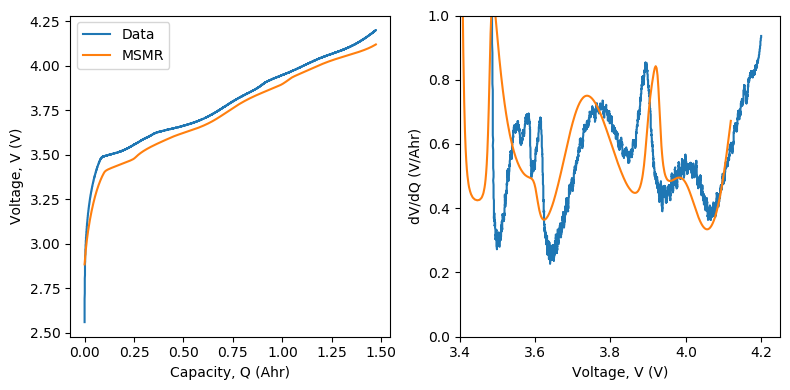

In [16]:
# We've now adapted the usable capacity to match that of the experimental data
cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=params_q, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = 0.27, neg_lower_li_limit = 0.0108,
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = fresh_capacity_51.max(), Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                                           all_output=False)

fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(fresh_capacity_51, fresh_voltage_51, label='Data')
ax.plot(cap, voltage, label='MSMR')
ax.set_ylabel('Voltage, V (V)')
ax.set_xlabel('Capacity, Q (Ahr)')
ax.legend()

ax2.plot(fresh_voltage_51, fresh_dudq_51)
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage, V (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0, 1)
ax2.set_xlim(3.4, 4.25)
plt.tight_layout()

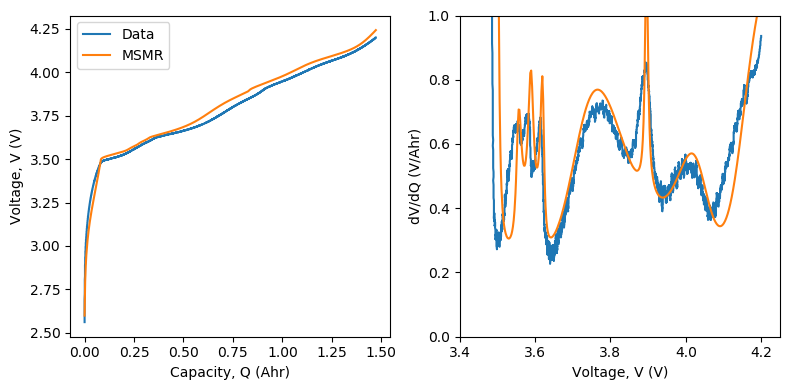

In [22]:
# Thus, we will manipulate the parameters within reasonable boundaries until the results are closer
# in parity. Here, the following matrix completes that task.

pos_c = 1.8
neg_c = 1.98

# Here, we are using the extensive form, and the fresh guess matrix has the positive electrode
# and negative electrode parameters. Additionally, two more parameters can be fit using the 
# software and those are the lower lithiation limits for each of the positive electrode
# which here, are already just in the extensive form.

fresh_guess = np.array([3.6827400e+00, 1.0268194e-01*pos_c, 9.6710000e-01, # Positive Electrode
                        3.7264500e+00, 2.4795833e-01*pos_c, 1.3971200e+00, 
                        3.9057500e+00, 1.6131806e-01*pos_c, 3.5050000e+00, 
                        4.2605500e+00, 2.5193056e-01*pos_c, 5.5275700e+00,
                        4.0117300e+00, 1.3002639e-01*pos_c, 1.5200000e+00, 
                        4.1690200e+00, 1.0608472e-01*pos_c, 9.3000000e-01, 
                        
                        7.5430000e-02, 5.7137000e-01*neg_c, 8.6110000e-02, # Negative Electrode
                        1.0299000e-01, 2.5463000e-01*neg_c, 8.0090000e-02,
                        1.2431000e-01, 2.4680000e-02*neg_c, 1.5000000e-01, 
                        1.4634000e-01, 2.7120000e-02*neg_c, 1.7500000e-01, 
                        1.6846000e-01, 6.7440000e-02*neg_c, 1.2200000e-01, 
                        3.6325000e-01, 5.4760000e-02*neg_c, 5.9735400e+00,
                        
                        0.185, 0.001]) # Lower Lithiation Bounds

# We can see that with this guess, the model and results are much closer in parity.

cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=fresh_guess, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = fresh_guess[-2], neg_lower_li_limit = fresh_guess[-1],
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = fresh_capacity_51.max(), Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                                           all_output=False)

fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(fresh_capacity_51, fresh_voltage_51, label='Data')
ax.plot(cap, voltage, label='MSMR')
ax.set_ylabel('Voltage, V (V)')
ax.set_xlabel('Capacity, Q (Ahr)')
ax.legend()

ax2.plot(fresh_voltage_51, fresh_dudq_51)
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage, V (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0, 1)
ax2.set_xlim(3.4, 4.25)
plt.tight_layout()

## Fitting the Data

Now that we have a good initial guess, we can start to fit the data. Here, we will use a Scipy package called ```fmin_slsqp``` which utilizes Sequential Least Squares Programming.

In [46]:
# First, we have to set bounds for each parameter. We first make an empty list, and then 
# iterate through, and change it so that each U0 can vary by +/- 20 mV, and then Qj
# and wj values can vary up by +/- 25% of their original value.

# Here, we add bounds for the lower lithiation limits of the positive and negative electrode
# We also change the Qj bounds for the two LMO reactions to be much tighter so that the fit
# stays true to what we know our material is.

fresh_ocv_bounds = []
nor_pos, nor_neg = 6,6
for i in range(0,int(nor_pos+nor_neg)):
    fresh_ocv_bounds.append((fresh_guess[i*3] - 0.02, fresh_guess[i*3] + 0.02))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 1]*0.75, fresh_guess[i*3 + 1]*1.25))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 2]*0.75, fresh_guess[i*3 + 2]*1.25))

fresh_ocv_bounds.append((0.18, 0.27))
fresh_ocv_bounds.append((0, 0.0108))
    
fresh_ocv_bounds[13] = (fresh_guess[13]*0.95, fresh_guess[13]*1.05)
fresh_ocv_bounds[16] = (fresh_guess[16]*0.95, fresh_guess[16]*1.05)

# Fitting
# The list of arguments needed to run the optimization function is commented for easier interpretation
# Under eqcons, one can list constraints. Here we will explore the constraints if the voltages at
# usable capacity = 0 and usable capacity = max must be equal between model and experiment.

# Here, we are setting "fixed Xj or Qj" to be True, so we can ignore the fit variables. Because
# we are not imposing strict capacity or lithium amount constraints, we can ignore the N|P ratio
# and positive electrode full capacity inputs.

# We are also fitting only using the dUdQ data. This can be changed if you want more weighting on
# the open-circuit voltage or differential voltage.
yvolt0_51c = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=fresh_guess, 
                        args=(voltage_range_c,             # interpolated voltage range
                              data_cap_interp_51,       # interpolated capacity data
                              data_dudq_interp_51,     # interpolated dudq data
                              fresh_voltage_51.min(),   # Minimum voltage
                              fresh_voltage_51.max(),   # Maximum voltage
                              298,                       # temperature
                              6, 6,                      # number of pos rxns, number of neg rxns
                              (3.4,5), (0,1),            # positive voltage range, negative voltange range
                              0.185, 0.001,                 # positive | neg lower X or Q limit
                              None,                      # N|P Ratio
                              None,                      # positive electrode full capacity
                              fresh_capacity_51.max(),  # usable/cyclable capacity within the voltage limits
                              'Qj', 'MAE',              # Qj or Xj
                              None,                      # list of pos_U0s
                              None,                      # list of neg_U0s
                              False, True,               # fixed voltage | fixed Xj or Qj limit
                              0.5, 0.5),                 # capacity vs dudq weight on error function
                        eqcons=[msmr.lower_v_constraint, msmr.upper_v_constraint],
                        bounds=fresh_ocv_bounds, iter=500, full_output=False)

print(yvolt0_51c)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.021688745372023213
            Iterations: 95
            Function evaluations: 3854
            Gradient evaluations: 95
[3.66304799e+00 2.31034365e-01 7.25325000e-01 3.74645000e+00
 4.06924595e-01 1.07204849e+00 3.88841390e+00 3.06174882e-01
 2.65562346e+00 4.26206383e+00 3.91940094e-01 4.14567750e+00
 4.01879078e+00 2.22345127e-01 1.47206887e+00 4.15278880e+00
 1.81404871e-01 1.11839942e+00 7.73795635e-02 1.25073890e+00
 1.07637500e-01 1.07780425e-01 5.49293442e-01 1.00112500e-01
 1.31922161e-01 6.10680693e-02 1.85111173e-01 1.53861758e-01
 6.11243260e-02 2.18750000e-01 1.77128207e-01 1.64802757e-01
 1.52500000e-01 3.43250000e-01 8.13186000e-02 6.82759930e+00
 1.85000000e-01 1.00000000e-03]


The parameters you get from this (in this case, yvolt0_51c) are your fit parameters against the input experimental data, where the 
* index [0:(nor_pos * 3)] are your positive electrode parameters
* index [(nor_pos * 3):-2] are your negative electrode parameters
* index [-2] is your positive electrode lower lithium or Q bound
* index [-1] is your negative electrode lower lithium or Q bound

Positive Electrode capacity is 1.7398239340132504
Negative Electrode Capacity is 2.168346094831126


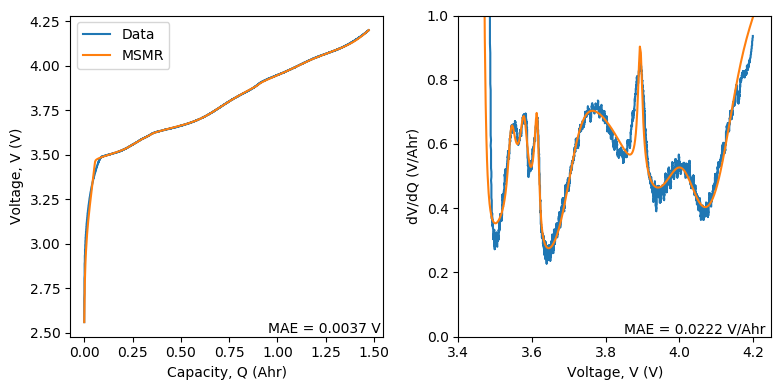

In [47]:
guess_51c = yvolt0_51c[0:(nor_pos+nor_neg)*3] # This will only pull the electrode params and not lower li params

cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=guess_51c, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = 0.185, neg_lower_li_limit = 0.001,
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = fresh_capacity_51.max(), Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                                           all_output=False)
capacity_range = np.linspace(fresh_capacity_51.min(), fresh_capacity_51.max(), 1000)
fit_v_capcon = msmr.mae(fresh_voltage_51, voltage, cap, fresh_capacity_51, capacity_range)
fit_dvdq_capcon = msmr.mae(fresh_dudq_51, (-dudq), voltage, fresh_voltage_51, np.linspace(3.49, 4.15, 1000))

fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(fresh_capacity_51, fresh_voltage_51, label='Data')
ax.plot(cap, voltage, label='MSMR')
ax.set_ylabel('Voltage, V (V)')
ax.set_xlabel('Capacity, Q (Ahr)')
ax.text(x=0.95, y=2.5, s='MAE = {} V'.format(np.round(fit_v_capcon, 4)))
ax.legend()

ax2.plot(fresh_voltage_51, fresh_dudq_51)
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage, V (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0, 1)
ax2.set_xlim(3.4, 4.25)
ax2.text(x=3.85, y=0.01, s='MAE = {} V/Ahr'.format(np.round(fit_dvdq_capcon,4)))
plt.tight_layout()

print('Positive Electrode capacity is {}'.format(yvolt0_51c[1:nor_pos*3:3].sum()))
print('Negative Electrode Capacity is {}'.format(yvolt0_51c[nor_pos*3+1:-2:3].sum()))

From this fit, we see that the model fits extremely well to the data, with the points at the upper and lower voltage limits matching, and the peaks in the dU/dQ are well captured. However, the electrode total electrode capacities have changed from our initial guesses. Since we did not have that information available, we decided to not constrain this quantity and instead leave it flexible.

Alternatively, we can change the constraints to match the true insertion capacities instead, if that information is available. For now, we will leave off the constraint that has the voltages match at 0 and 100% SoC

In [48]:
# Reusing the same bounds as above

# Fitting
# Here, we will instead change the eqcons to the pos and neg li constraints. This now will require
# an entry in the 'positive electrode full capacity', and 'N|P' ratio.
yvolt0_51c = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=fresh_guess, 
                        args=(voltage_range_c,             # interpolated voltage range
                              data_cap_interp_51,       # interpolated capacity data
                              data_dudq_interp_51,     # interpolated dudq data
                              fresh_voltage_51.min(),   # Minimum voltage
                              fresh_voltage_51.max(),   # Maximum voltage
                              298,                       # temperature
                              6, 6,                      # number of pos rxns, number of neg rxns
                              (3.4,5), (0,1),            # positive voltage range, negative voltange range
                              0.185, 0.001,                 # positive | neg lower X or Q limit
                              1.1,                      # N|P Ratio
                              1.8,                      # positive electrode full capacity
                              fresh_capacity_51.max(),  # usable/cyclable capacity within the voltage limits
                              'Qj', 'MAE',              # Qj or Xj
                              None,                      # list of pos_U0s
                              None,                      # list of neg_U0s
                              False, True,               # fixed voltage | fixed Xj or Qj limit
                              0.5, 0.5),                 # capacity vs dudq weight on error function
                        eqcons=[msmr.pos_li_constraint, msmr.neg_li_constraint],
                        bounds=fresh_ocv_bounds, iter=500, full_output=False)

print(yvolt0_51c)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02281379861744306
            Iterations: 61
            Function evaluations: 2482
            Gradient evaluations: 61
[3.66274000e+00 2.31034365e-01 7.25325000e-01 3.74645000e+00
 4.16630658e-01 1.11309320e+00 3.88575000e+00 3.56493218e-01
 3.46766790e+00 4.27275318e+00 3.92091761e-01 5.50982131e+00
 4.02237900e+00 2.22345127e-01 1.64460546e+00 4.16205341e+00
 1.81404871e-01 1.14584243e+00 8.28870858e-02 1.06448547e+00
 1.07637500e-01 1.13016367e-01 5.48499568e-01 1.00112500e-01
 1.37551656e-01 6.10830000e-02 1.87500000e-01 1.59977774e-01
 5.83536594e-02 2.18750000e-01 1.84540203e-01 1.66259699e-01
 1.52500000e-01 3.43250000e-01 8.13186000e-02 5.97317284e+00
 1.85000000e-01 1.00000000e-03]


Positive Electrode capacity is 1.8
Negative Electrode Capacity is 1.98


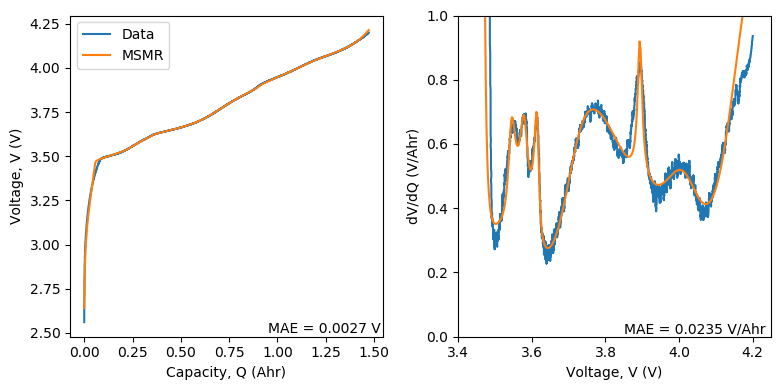

In [45]:
guess_51c = yvolt0_51c[0:(nor_pos+nor_neg)*3] # This will only pull the electrode params and not lower li params

cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=guess_51c, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = 0.185, neg_lower_li_limit = 0.001,
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = fresh_capacity_51.max(), Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                                           all_output=False)

capacity_range = np.linspace(fresh_capacity_51.min(), fresh_capacity_51.max(), 1000)
fit_v_capcon = msmr.mae(fresh_voltage_51, voltage, cap, fresh_capacity_51, capacity_range)
fit_dvdq_capcon = msmr.mae(fresh_dudq_51, (-dudq), voltage, fresh_voltage_51, np.linspace(3.49, 4.15, 1000))

fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(fresh_capacity_51, fresh_voltage_51, label='Data')
ax.plot(cap, voltage, label='MSMR')
ax.set_ylabel('Voltage, V (V)')
ax.set_xlabel('Capacity, Q (Ahr)')
ax.text(x=0.95, y=2.5, s='MAE = {} V'.format(np.round(fit_v_capcon, 4)))
ax.legend()

ax2.plot(fresh_voltage_51, fresh_dudq_51)
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage, V (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0, 1)
ax2.set_xlim(3.4, 4.25)
ax2.text(x=3.85, y=0.01, s='MAE = {} V/Ahr'.format(np.round(fit_dvdq_capcon,4)))
plt.tight_layout()

print('Positive Electrode capacity is {}'.format(yvolt0_51c[1:nor_pos*3:3].sum()))
print('Negative Electrode Capacity is {}'.format(yvolt0_51c[nor_pos*3+1:-2:3].sum()))



Here we see that the capacity and N|P ratio we put in is conserved, and the fitting is similar to error. However, what we notice is that the voltages at Q = 0 Ahr and Q = $\Delta$Q do not match up anymore. The peaks in the dudQ are still captured nicely.

Alternatively, we can implement the same optimization routine, but also change the weighting of the voltage vs dU/dQ components. Here, instead of equal weighting, let's explore if the fit changes if we just focus on the differential component.

In [49]:
# Reusing the same bounds as above

# Fitting
# Here, we will instead change the eqcons to the pos and neg li constraints. This now will require
# an entry in the 'positive electrode full capacity', and 'N|P' ratio.
yvolt0_51c = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=fresh_guess, 
                        args=(voltage_range_c,             # interpolated voltage range
                              data_cap_interp_51,       # interpolated capacity data
                              data_dudq_interp_51,     # interpolated dudq data
                              fresh_voltage_51.min(),   # Minimum voltage
                              fresh_voltage_51.max(),   # Maximum voltage
                              298,                       # temperature
                              6, 6,                      # number of pos rxns, number of neg rxns
                              (3.4,5), (0,1),            # positive voltage range, negative voltange range
                              0.185, 0.001,                 # positive | neg lower X or Q limit
                              1.1,                      # N|P Ratio
                              1.8,                      # positive electrode full capacity
                              fresh_capacity_51.max(),  # usable/cyclable capacity within the voltage limits
                              'Qj', 'MAE',              # Qj or Xj
                              None,                      # list of pos_U0s
                              None,                      # list of neg_U0s
                              False, True,               # fixed voltage | fixed Xj or Qj limit
                              0.0, 1.0),                 # capacity vs dudq weight on error function
                        eqcons=[msmr.pos_li_constraint, msmr.neg_li_constraint],
                        bounds=fresh_ocv_bounds, iter=500, full_output=False)

print(yvolt0_51c)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04340925996576636
            Iterations: 56
            Function evaluations: 2295
            Gradient evaluations: 56
[3.66274000e+00 2.31034365e-01 7.25325000e-01 3.74645000e+00
 4.15944092e-01 1.15506405e+00 3.88575000e+00 3.44348759e-01
 3.45195594e+00 4.26792264e+00 4.04922785e-01 5.50648427e+00
 4.02057913e+00 2.22345127e-01 1.61273633e+00 4.16231396e+00
 1.81404871e-01 1.16250000e+00 8.38011429e-02 1.06693545e+00
 1.07637500e-01 1.14014949e-01 5.42758626e-01 1.00112500e-01
 1.38300264e-01 6.10830000e-02 1.87500000e-01 1.60685773e-01
 5.94703622e-02 2.18750000e-01 1.84931111e-01 1.66914000e-01
 1.52500000e-01 3.43250000e-01 8.28385606e-02 5.97019775e+00
 1.85000000e-01 1.00000000e-03]


Positive Electrode capacity is 1.8
Negative Electrode Capacity is 1.98


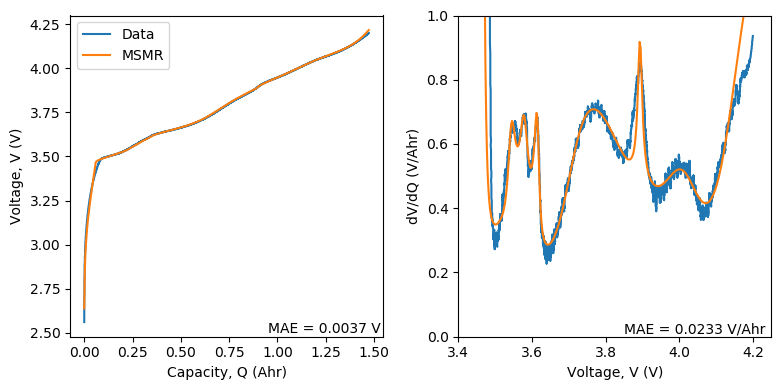

In [51]:
guess_51c = yvolt0_51c[0:(nor_pos+nor_neg)*3] # This will only pull the electrode params and not lower li params

cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=guess_51c, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = 0.185, neg_lower_li_limit = 0.001,
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = fresh_capacity_51.max(), Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                                           all_output=False)

capacity_range = np.linspace(fresh_capacity_51.min(), fresh_capacity_51.max(), 1000)
fit_v_capcon = msmr.mae(fresh_voltage_51, voltage, cap, fresh_capacity_51, capacity_range)
fit_dvdq_capcon = msmr.mae(fresh_dudq_51, (-dudq), voltage, fresh_voltage_51, np.linspace(3.49, 4.15, 1000))

fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(fresh_capacity_51, fresh_voltage_51, label='Data')
ax.plot(cap, voltage, label='MSMR')
ax.set_ylabel('Voltage, V (V)')
ax.set_xlabel('Capacity, Q (Ahr)')
ax.text(x=0.95, y=2.5, s='MAE = {} V'.format(np.round(fit_v_capcon, 4)))
ax.legend()

ax2.plot(fresh_voltage_51, fresh_dudq_51)
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage, V (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0, 1)
ax2.set_xlim(3.4, 4.25)
ax2.text(x=3.85, y=0.01, s='MAE = {} V/Ahr'.format(np.round(fit_dvdq_capcon,4)))
plt.tight_layout()

print('Positive Electrode capacity is {}'.format(yvolt0_51c[1:nor_pos*3:3].sum()))
print('Negative Electrode Capacity is {}'.format(yvolt0_51c[nor_pos*3+1:-2:3].sum()))

We see that by also incorporating the removing the capacity curve from the fitting scheme, our capacity error inherently goes up and we see marginal gains in reduced error on the differential side. This approach may be favorable if one intends to prioritize enhanced fitting on the peaks in the differential curve instead.

Next possible logic is to see if we can impose all sets of constraints, but this can lead to an overconstrained problem, and the optimization may not meet all the constraints given.

In [52]:
# Reusing the same bounds as above

# Fitting
# Here, we will see what happens if we try to impose all the constraints on the system.
yvolt0_51c = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=fresh_guess, 
                        args=(voltage_range_c,             # interpolated voltage range
                              data_cap_interp_51,       # interpolated capacity data
                              data_dudq_interp_51,     # interpolated dudq data
                              fresh_voltage_51.min(),   # Minimum voltage
                              fresh_voltage_51.max(),   # Maximum voltage
                              298,                       # temperature
                              6, 6,                      # number of pos rxns, number of neg rxns
                              (3.4,5), (0,1),            # positive voltage range, negative voltange range
                              0.185, 0.001,                 # positive | neg lower X or Q limit
                              1.1,                      # N|P Ratio
                              1.8,                      # positive electrode full capacity
                              fresh_capacity_51.max(),  # usable/cyclable capacity within the voltage limits
                              'Qj', 'MAE',              # Qj or Xj
                              None,                      # list of pos_U0s
                              None,                      # list of neg_U0s
                              False, True,               # fixed voltage | fixed Xj or Qj limit
                              0.0, 1.0),                 # capacity vs dudq weight on error function
                        eqcons=[msmr.pos_li_constraint, msmr.neg_li_constraint,
                                msmr.lower_v_constraint, msmr.upper_v_constraint],
                        bounds=fresh_ocv_bounds, iter=500, full_output=False)

print(yvolt0_51c)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.043767294187423714
            Iterations: 68
            Function evaluations: 2766
            Gradient evaluations: 68
[3.66274000e+00 2.31034365e-01 7.25325000e-01 3.74625033e+00
 4.15055566e-01 1.13377947e+00 3.88575000e+00 3.62965635e-01
 3.60206922e+00 4.25849547e+00 3.87194436e-01 5.32880985e+00
 4.01968490e+00 2.22345127e-01 1.62558188e+00 4.16181578e+00
 1.81404871e-01 1.14049118e+00 8.27638472e-02 1.05693376e+00
 1.07637500e-01 1.12843428e-01 5.48730933e-01 1.00112500e-01
 1.37273503e-01 6.10830000e-02 1.87500000e-01 1.59787920e-01
 5.96703319e-02 2.18750000e-01 1.84257215e-01 1.66914000e-01
 1.52500000e-01 3.43250000e-01 8.66679755e-02 6.90373603e+00
 1.85000000e-01 1.00000000e-03]


Positive Electrode capacity is 1.8
Negative Electrode Capacity is 1.9800000000000002


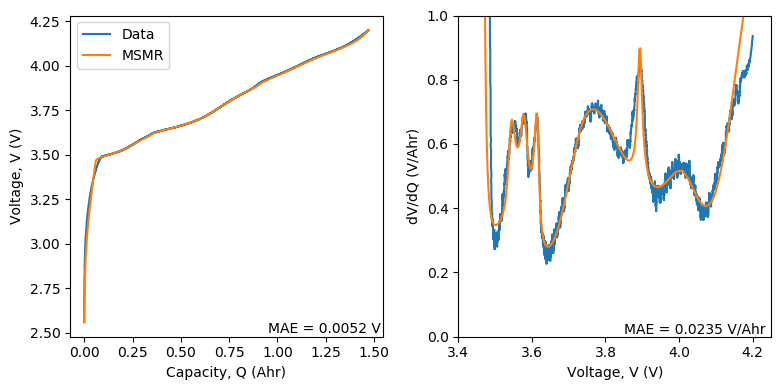

In [53]:
guess_51c = yvolt0_51c[0:(nor_pos+nor_neg)*3] # This will only pull the electrode params and not lower li params

cap, voltage, dqdu, dudq = msmr.whole_cell(parameter_matrix=guess_51c, nor_pos = 6, nor_neg = 6,
                                           pos_lower_li_limit = 0.185, neg_lower_li_limit = 0.001,
                                           temp = 298, pos_volt_range = (3.4,5), neg_volt_range = (0,1),
                                           usable_cap = fresh_capacity_51.max(), Qj_or_Xj='Qj', n_p=None, p_capacity=None, 
                                           all_output=False)

capacity_range = np.linspace(fresh_capacity_51.min(), fresh_capacity_51.max(), 1000)
fit_v_capcon = msmr.mae(fresh_voltage_51, voltage, cap, fresh_capacity_51, capacity_range)
fit_dvdq_capcon = msmr.mae(fresh_dudq_51, (-dudq), voltage, fresh_voltage_51, np.linspace(3.49, 4.15, 1000))


fig = plt.figure(figsize = (8,4))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax.plot(fresh_capacity_51, fresh_voltage_51, label='Data')
ax.plot(cap, voltage, label='MSMR')
ax.set_ylabel('Voltage, V (V)')
ax.set_xlabel('Capacity, Q (Ahr)')
ax.text(x=0.95, y=2.5, s='MAE = {} V'.format(np.round(fit_v_capcon, 4)))

ax.legend()

ax2.plot(fresh_voltage_51, fresh_dudq_51)
ax2.plot(voltage, -dudq)
ax2.set_xlabel('Voltage, V (V)')
ax2.set_ylabel('dV/dQ (V/Ahr)')
ax2.set_ylim(0, 1)
ax2.set_xlim(3.4, 4.25)
ax2.text(x=3.85, y=0.01, s='MAE = {} V/Ahr'.format(np.round(fit_dvdq_capcon,4)))
plt.tight_layout()

print('Positive Electrode capacity is {}'.format(yvolt0_51c[1:nor_pos*3:3].sum()))
print('Negative Electrode Capacity is {}'.format(yvolt0_51c[nor_pos*3+1:-2:3].sum()))

In this case, we get a solution that converges, but it is not uncommon to run into a scenario where the problem is overconstraint and a solution cannot be found that satisfies all the constraints. In this case, the fitting optimization can break down and lead to no proper fit.